## Dataset loading

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from utils import data

dataset_path = './dataset/'
dataset_files = ['TcData.csv' ,'BsData.csv']

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    #"device": torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"),
}
pd.set_option("display.max_columns", None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

#load dfs
dfs = dict([])
for file in dataset_files:
    df = pd.read_csv(os.path.join(dataset_path,file), na_values=0)
    df = df.rename(columns={'Composition': 'formula'})
    #this featurization takes a long time so load it instead.
    df = data.featurize_data(
        df,load_existing_df=True, 
        pkl_path = os.path.join(dataset_path, 
                                f"./df_data_{file[:2]}.pkl")
    )
    df.name = file[:2]
    dfs[df.name] = df

## Surrogate definition
I wrote this surrogate class to handle heavy utility function and analysis work. You can see how handy it is.

In [2]:
from utils.surrogate import surrogate_model

Tc_surrogate = surrogate_model(name='Tc', df=dfs['Tc'])
Bs_surrogate = surrogate_model(name='Bs', df=dfs['Bs'])

#Here we clean up data by removing columns with NaN
Tc_surrogate.cleanup_df(drop_NaN = False, 
                        drop_col_with_NaN = True)
Bs_surrogate.cleanup_df(drop_NaN = False, 
                        drop_col_with_NaN = True)

#internally create and store training/test set
Tc_surrogate.split_train_test(test_size=0.2, seed=1)
Bs_surrogate.split_train_test(test_size=0.2, seed=1)

surrogates = [Tc_surrogate, Bs_surrogate] 

## GPR Model definition and training

Assign training data and target then train them. As a bonus check for as defined in the surrogate_model class.

In [3]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.models.transforms.input import ChainedInputTransform
from utils.model import (
    NormalizeElementFractions, 
    NormalizeFeatures,
    test_features_normalized,
    train_model)

def initialize_model(X,y):
    outcome_transform = Standardize(m=1)
    normalize_other = NormalizeFeatures(indices=surrogates[0].to_scale_col)
    normalize_EF = NormalizeElementFractions(indices=surrogates[0].EF_col)
    # here I only normalize elemental fragment
    # GP model will complain but I haven't found
    #not normalizing thickness to be an issue
    input_transform = ChainedInputTransform(
        #tf1=normalize_other, 
        tf2=normalize_EF,
    )
    model = SingleTaskGP(
        train_X = X, 
        train_Y = y,
        input_transform = input_transform,
    outcome_transform =outcome_transform,
    covar_module = ScaleKernel(RBFKernel()),
    )
    return model

for surrogate_model in surrogates:
    surrogate_model.model = None
    #make sure the dims are n_entries x n_features for 1 obj
    surrogate_model.model = initialize_model(torch.tensor(surrogate_model.X), 
                                             torch.tensor(surrogate_model.y).unsqueeze(dim=-1)
                                            )
    print("-------------------")
    surrogate_model.model.train()
    train_model(surrogate_model.model, lr=3e-2)
    surrogate_model.test_invariance()

/Users/ktrerayapiwat/miniconda3/envs/matminer-Ax/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


-------------------
Epoch  50/200 - Loss: 0.940 noise: 0.350
Epoch 100/200 - Loss: 0.692 noise: 0.095
Epoch 150/200 - Loss: 0.691 noise: 0.088
Epoch 200/200 - Loss: 0.691 noise: 0.087
-------------------
Model Tc is invariance to scaling elemental fractions: True
-------------------


/Users/ktrerayapiwat/Software/Fe_alloy_phaseshift/utils/model.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = model.posterior(torch.tensor(X, **tkwargs))
/Users/ktrerayapiwat/miniconda3/envs/matminer-Ax/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


Epoch  50/200 - Loss: 0.985 noise: 0.380
Epoch 100/200 - Loss: 0.864 noise: 0.159
Epoch 150/200 - Loss: 0.861 noise: 0.166
Epoch 200/200 - Loss: 0.861 noise: 0.167
-------------------
Model Bs is invariance to scaling elemental fractions: True


/Users/ktrerayapiwat/Software/Fe_alloy_phaseshift/utils/model.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = model.posterior(torch.tensor(X, **tkwargs))


## Plot parity
Defined internally to plot surrogate model parity and uncertainty/prediction error plot

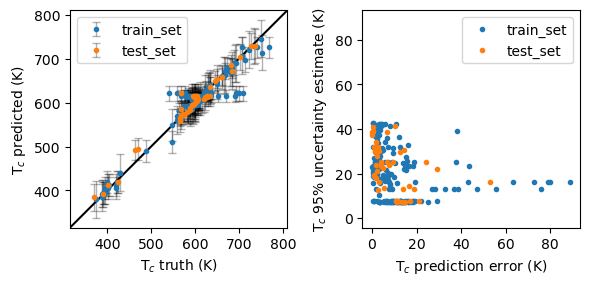

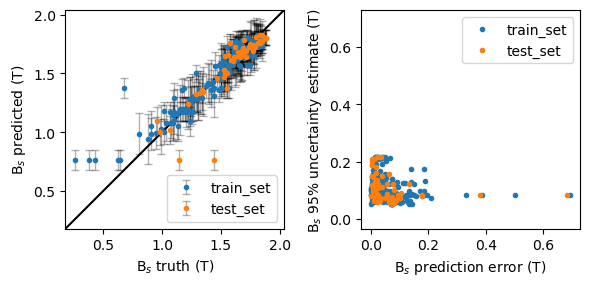

In [4]:
for surrogate_model in [Tc_surrogate, Bs_surrogate]:
    surrogate_model.plot_train_test_fit(save_fig = True)